In [33]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import missingno as miss
from string import punctuation
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
import nltk

In [34]:
data = pd.read_csv('all-data.csv',delimiter=',',encoding='latin-1')
data.head()

,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


Let's see how many entries are there in this dataset

In [35]:
data.shape

(4845, 2)

There're 2 columns with 4845 rows 

Renaming the columns to some appropriate names

In [36]:
data = data.rename(columns={'neutral':'sentiment'})
data = data.rename(columns={'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .':'headline'})
data.head()

,sentiment,headline
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [37]:
data.index = range(4845)
data['headline'].apply(lambda x: len(x.split(' '))).sum()

111964

The sentiment is indicated by a word, we need to change to a number. Let's change negative to 0, neutral to 1, and positive to 2

In [38]:
lab = LabelEncoder()
label = lab.fit_transform(data['sentiment'])
label

array([1, 0, 2, ..., 0, 0, 0])

In [39]:
data.drop("sentiment", axis=1, inplace=True)
data["sentiment"] = label
data

,headline,sentiment
0,Technopolis plans to develop in stages an area...,1
1,The international electronic industry company ...,0
2,With the new production plant the company woul...,2
3,According to the company 's updated strategy f...,2
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,2
...,...,...
4840,LONDON MarketWatch -- Share prices ended lower...,0
4841,Rinkuskiai 's beer sales fell by 6.5 per cent ...,1
4842,Operating profit fell to EUR 35.4 mn from EUR ...,0
4843,Net sales of the Paper segment decreased to EU...,0


now we have the sentiment labeled as a number, which is more convenient 

## Data Cleaning
lets see if there're any missing values 

In [40]:
data.isnull().sum()

headline     0
sentiment    0
dtype: int64

as we can see there're no missing values in this dataset.
Are there any duplicate values?

In [41]:
data.duplicated().sum()

6

deleting them 

In [42]:
data.drop_duplicates(keep='first',inplace=True)

Checking if the duplicates deleted properly and there's the same amount of entries in both columns

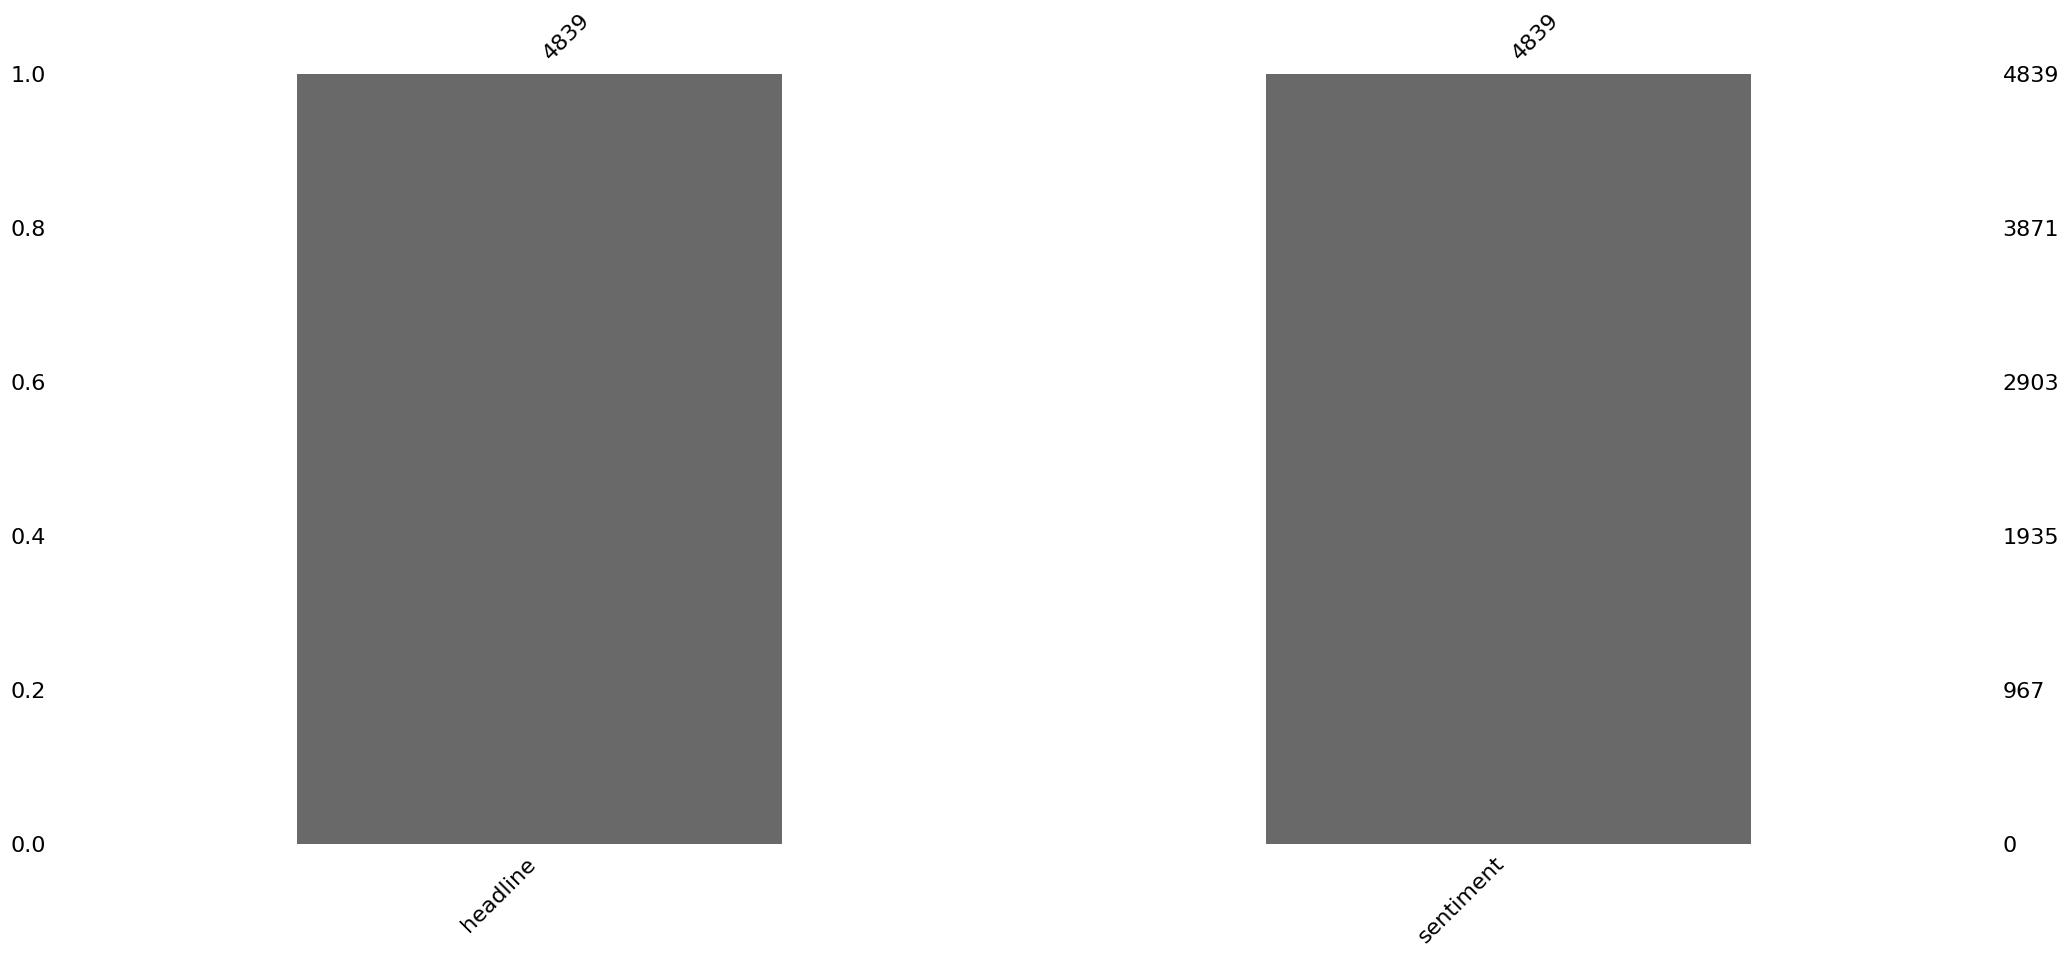

In [43]:
miss.bar(data)
plt.show()

Now lets check the counts of specific sentiments in a dataset and visualize in a bar chart in order to make the differences more visible 

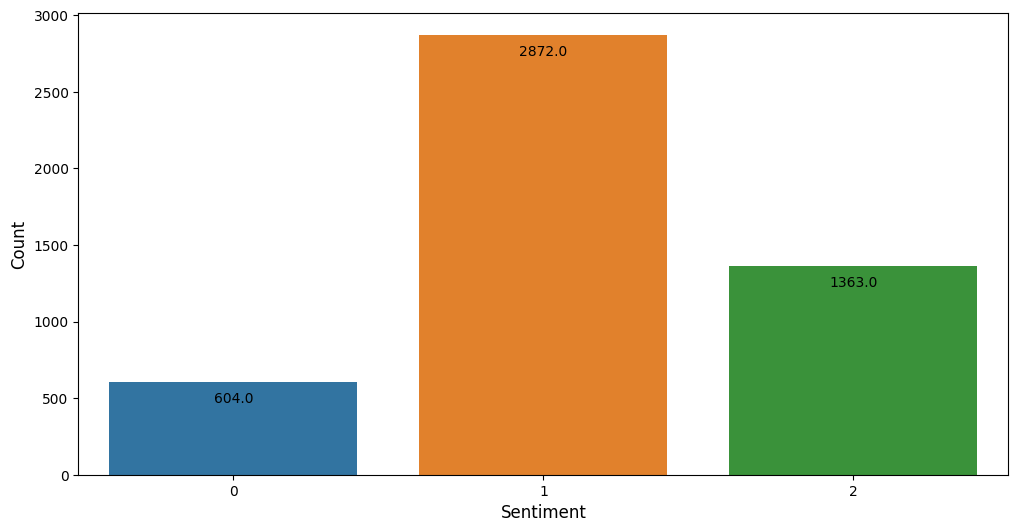

In [44]:
sent_counts = data['sentiment'].value_counts()
plt.figure(figsize=(12,6))
splot = sns.barplot(x=sent_counts.index, y=sent_counts.values)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, -12), 
                   textcoords = 'offset points')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.show();

now we can see that the biggest sentiment group is neutral with 2872 entries, posiive group is on the second place with around 2 times less entries - 1363, the negative sentiment group has the least entries, 604.  

## Text preprocessing 

In [46]:
import string


#lowercasing
data['headline'] = data['headline'].str.lower()

#tokenization
data['headline'] = data['headline'].apply(lambda x: str(x))
data['headline'] = data['headline'].apply(lambda x: nltk.word_tokenize(x))

#removing punctuation
data['headline'] = data['headline'].apply(lambda tokens: [token for token in tokens if token not in string.punctuation])

#removing stopwords
stop_words = set(stopwords.words('english'))
data['headline'] = data['headline'].apply(lambda tokens: [token for token in tokens if token not in stop_words])

#lemmatization
lemmatizer = WordNetLemmatizer()
data['headline'] = data['headline'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

#removing special characters and numbers
data['headline'] = data['headline'].apply(lambda tokens: [token for token in tokens if token.isalpha()])

#joining tokens back into a string
data['headline'] = data['headline'].apply(' '.join)

In [47]:
data.head()

,headline,sentiment
0,technopolis plan develop stage area le square ...,1
1,international electronic industry company elco...,0
2,new production plant company would increase ca...,2
3,according company updated strategy year baswar...,2
4,financing aspocomp growth aspocomp aggressivel...,2


## Classification task

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

#splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['headline'], data['sentiment'], test_size=0.3, random_state=42)

#TF-IDF vectorizer 
vectorizer = TfidfVectorizer()

#fit the vectorizer on the training data and transform the training and testing data
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

#linearSVC classifier
classifier = LinearSVC()
classifier.fit(X_train, y_train)

#prediction  
y_pred = classifier.predict(X_test)

#evaluation of the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7493112947658402
              precision    recall  f1-score   support

           0       0.75      0.51      0.61       189
           1       0.78      0.89      0.83       855
           2       0.67      0.57      0.61       408

    accuracy                           0.75      1452
   macro avg       0.73      0.66      0.68      1452
weighted avg       0.74      0.75      0.74      1452



## Clustering

finding the optimal number of clusters using an elbow curve  

In [49]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data["headline"])

wcss = []
max_clusters = 10  

for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)


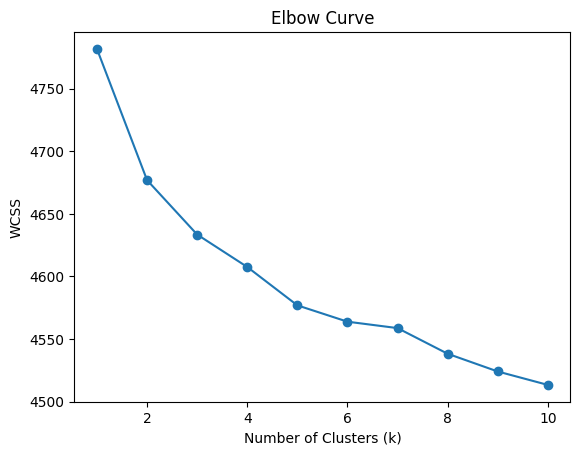

In [50]:
plt.plot(range(1, max_clusters + 1), wcss, marker='o')
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


clustering itself

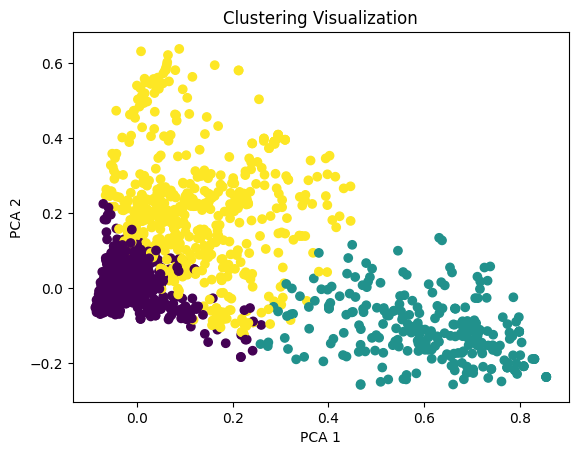

In [52]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

#visualizing clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap="viridis")
plt.title("Clustering Visualization")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

clustering evaluation

In [54]:
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score

ch_score_kmeans = calinski_harabasz_score(X.toarray(), kmeans.labels_)
silhouette_score_kmeans = silhouette_score(X.toarray(), kmeans.labels_)

print(f"Calinski-harabasz score equals to {ch_score_kmeans.round(2)}, silhouette score equals to {silhouette_score_kmeans.round(2)}")

Calinski-harabasz score equals to 77.4, silhouette score equals to 0.01


## Collocation analysis

In [55]:
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

words = ' '.join(data["headline"]).split()

finder = BigramCollocationFinder.from_words(words)
collocations = finder.nbest(BigramAssocMeasures.likelihood_ratio, 10)  

print("\nCollocations:")
for collocation in collocations:
    print(" ".join(collocation))



Collocations:
eur mn
net sale
operating profit
eur million
corresponding period
euro mln
mln euro
oyj hel
omx helsinki
stora enso


## Most used words word clouds 

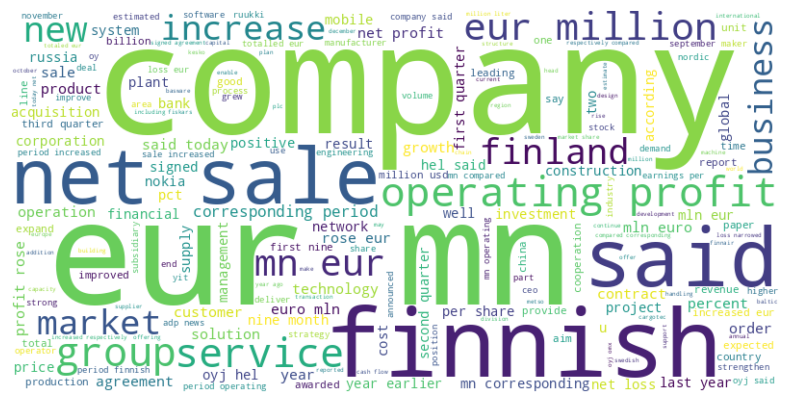

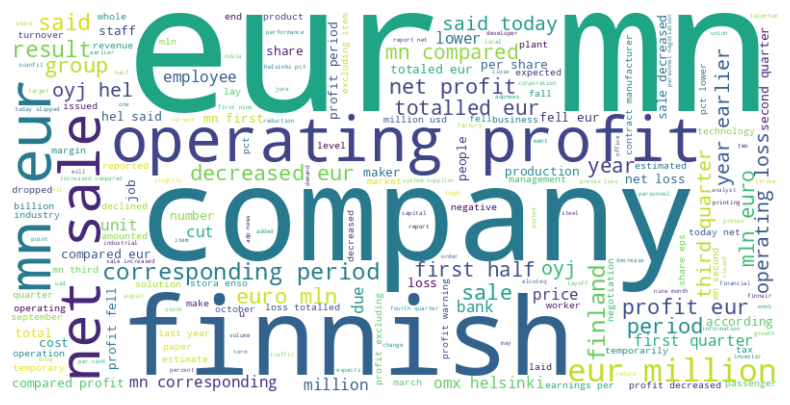

In [56]:
from wordcloud import WordCloud

positive_df = data[data["sentiment"] == 2]
negative_df = data[data["sentiment"] == 0]

def generate_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

generate_word_cloud(" ".join(positive_df["headline"]))
generate_word_cloud(" ".join(negative_df["headline"]))
